In [1]:
pip install -Uqq fastbook

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install streamlit

In [ ]:
!unzip -q /content/cats.zip -d ../

Import relevant libraries

In [2]:

import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.vision.widgets import *
from pathlib import Path

In [3]:
fns = get_image_files('./cats')

### Dataloader
Before training, we want to let the model know:

the types of data
how to get data
how to get the labels of the dataset
how to split the data into train and validation set
That is when Dataloader comes in handy. Start with creating DataBlock and feed this instance to dataloaders

In [4]:

cats = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=1),
    get_y=parent_label,
    item_tfms=Resize(128))
    
dls = cats.dataloaders('./cats/')

View 4 random images in our dataloaders

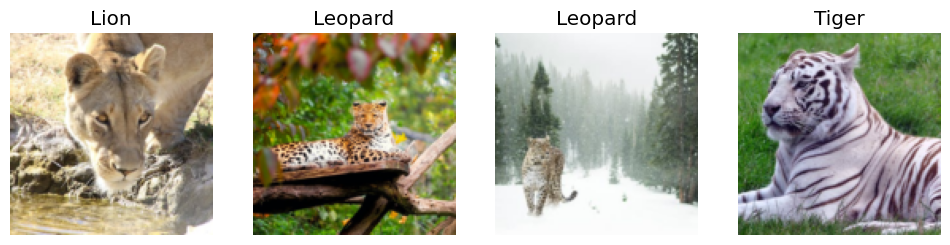

In [5]:
dls.valid.show_batch(max_n=4, nrows=1)

# Random Resize and Data Augmentation
The images above are good as they are. But for the neural network to capture more of our images, we want to improve our method of transforming images. That could be done by using random resize and data augmentation.

# Random Resize
For many types of neural networks, the inputs always need to have the same shape. So we want to crop the images so that they are all the same size.

By default, Resize crops the images to fit a square shape. This might result in a loss of important pieces of images. So instead of cropping the same area, we will use RandomResizedCrop to randomly select and crop one part of the image.

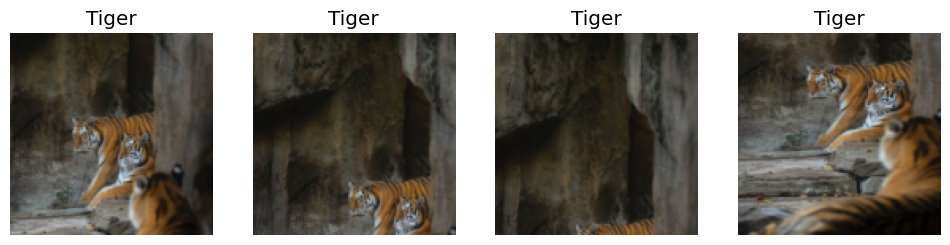

In [6]:
cats = cats.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = cats.dataloaders('./cats')
dls.train.show_batch(max_n=4, nrows=1, unique=True)

# Data Augmentation
To create more training data, we will use batch_tfms to apply augmentations to a whole dataset. This means to rotate, flip, change the brightness of the images, etc to create different images from the same image.

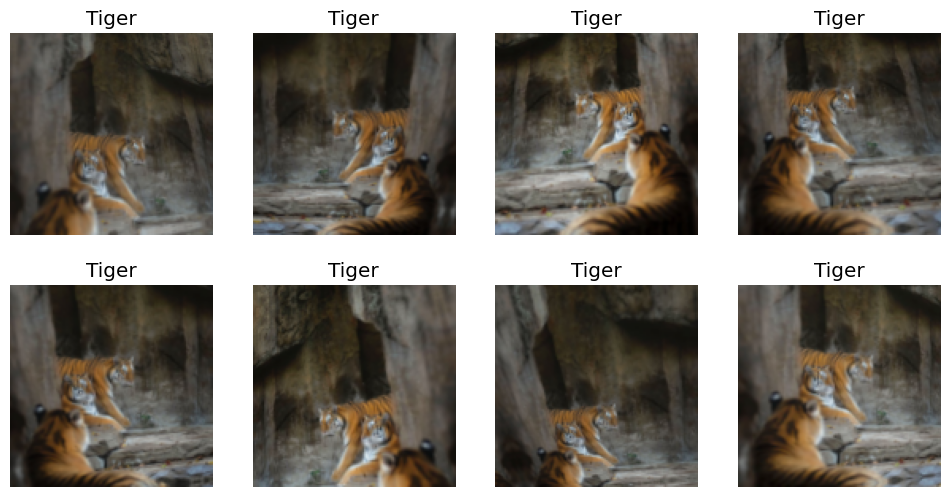

In [7]:
cats = cats.new(item_tfms=Resize(128), batch_tfms=aug_transforms())
dls = cats.dataloaders('./cats/')
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Combine both techniques to get the benefits of both transformations

In [8]:
cats = cats.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = cats.dataloaders('./cats/')

## Train our Model
We use a convolution neural network (CNN) with architecture ResNet to train our model. cnn_learner will also load a pre-trained model that have already been trained to recognize a thousand different categories across 1.3 million photos.

In [9]:
learn = cnn_learner(dls, resnet50, metrics=error_rate)
learn.fine_tune(4)

c:\Users\Princewell\AppData\Local\Programs\Python\Python310\lib\site-packages\fastai\vision\learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
c:\Users\Princewell\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Princewell\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.506003,0.238077,0.041475,40:26


epoch,train_loss,valid_loss,error_rate,time
0,0.128424,0.265637,0.052995,48:30
1,0.119629,0.233892,0.034562,48:39
2,0.096860,0.163984,0.025346,49:57
3,0.072753,0.159564,0.025346,1:10:20


## Evaluate our model

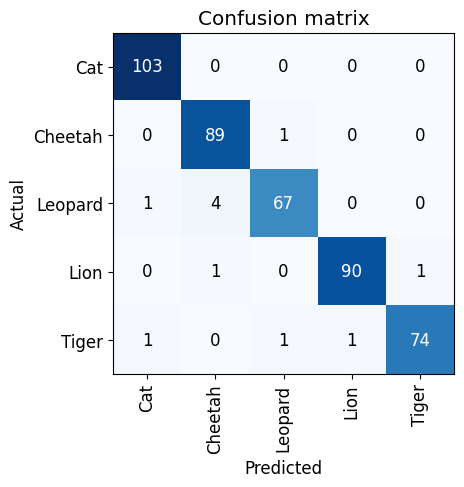

In [10]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

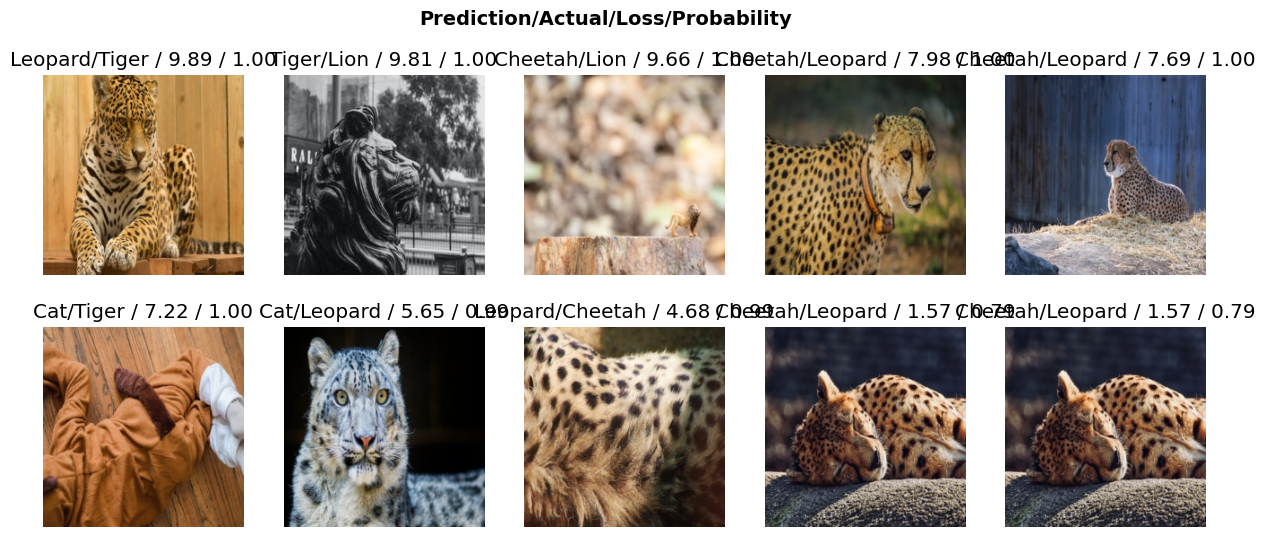

In [11]:
# Images wrongly classified
interp.plot_top_losses(10, nrows=2)

## Save the model
That’s it! Now we can export our model to put into production

In [12]:
learn.export('cats.pkl')